# TDA Analysis
#### Introduction

In this script, we will use the selected parameters to run kmapper on the entire cleaned LTRM data. We will create the simplicial complex, find the states, and then color the html file by various variables.

Within this script there is options to use one of the following parameter combinations:

1. All water quality variables
2. Removing TURB and SECCHI and only use SS
3. Remove water clarity variables (SS, TURB, and SECCHI) and analyze only nutrient variables

NOTE: Currently, we anticipate that we will be using the following water quality variables: WDP, SS, TN, TP, VEL, CHLcal, DO. This is because TURB and SECCHI are highly correlated with SS

#### Outline

This notebook will first make the following alterations to the cleaned and interpolated LTRM data:

1. Scale the conintuous variable columns with RobustScaler(). Robust scaler scales the data by subtracting the median and dividing by the IQR for each continuous variable.
2. Adding 5 decade columns with one-hot encoding
3. Adding 3 stratum columns with one-hot encoding
4. Adding 6 field number columns with one-hot encoding
5. New coloring columns for each continuous variable with a lower 'ceiling' - prevents outliers from skewing the color scale
6. New unscaled continuous variable columns 


We will then run kmapper with several different combinations of parameter values (epsilon, min samples, cubes, and percent overlap). Recall that we are using PCA 2 as the filter function. We will use the heuristics stated previously to choose a combination of parameters. 

The TDA analysis will include the following steps:

1. Run kmapper on the data set
2. Use the code written by Killan to find the density of each node in a simplicial complex
3. Convert the simplicial complex to a directed graph with arrows pointing to a node with a higher density
4. Local maxium will be defined as sinks of the directed graph
5. States of a local maximum will be made up of the nodes whose shortest graph distance to a local maximum is that local maximum
6. Color the simplicial complex by different variables to make inferences about the states in each region of the river
7. Make boxplots of the continuous variables for each state (this final step will be completed in a different jupyter notebook)


## Import libraries

In [1]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd
import numpy as np

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
# import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
import random
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [2]:
# Use this if using a pickle file with the scomplex already created
# dataFilePath = "../LTRM data2/LTRM_dfd.p"
# df = pk.load(open(dataFilePath, "rb"))['LTRM']

In [3]:
# Use this to run the analysis from scratch
water20 = pd.read_csv("../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                   "WDP","TEMP", "DO", "VEL", "TP", "TN", "SS", "CHLcal", 
                   "YEAR", "SEASON"]]

## Scale data

We will be using RobustScaler() to scale our data. For each continuous variable column RobustScaler will subtract the median of the column from every observation and divide by the IQR. We will be using RobustScaler instead of StandardScaler because it is robust to outliers. It is important that we scale our data so that every variable has equal opportunity to be significant in our principal components.

In [4]:
continuous_variables = ["WDP","TEMP", "DO", "VEL", "TP", "TN", "SS", "CHLcal"]

# Create unscaled columns
for variable in continuous_variables:
    column_name = variable + "_unscaled"
    water20[column_name] = water20[variable]

In [5]:
ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["WDP","TEMP", "DO", "VEL", "TP", "TN", "SS", "CHLcal",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON", 'WDP_unscaled', 'TEMP_unscaled', 'DO_unscaled',
                                             'VEL_unscaled', 'TP_unscaled', 'TN_unscaled', 'SS_unscaled',
                                             'CHLcal_unscaled'])

## Make new columns with one-hot encoding

In order to color the scomplex by categorical variables, we need to make dummy columns for the selected variables. A dummy column is a column that is filled with 1's and 0's depending on whether an observation meets a certain condition. In this case the conditions will be whether or a not an observations was taken in a year intercal, whether an observation belongs in a specific stratum, or whether and observations belongs in a specific pool.

### Make decade columns


In [6]:
eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

### Make STRATUM and FLDNUM columns

In [7]:
to_dummy_vars = ['STRATUM', 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

## Make coloring columns for continuous variables

Since the LTRM data has so many outliers for each continous variable, the color scale for the html is skewed strongly to the right. Kmapper uses min-max color scaling meaning that the smallest value is set to the left of the scale and the largest values is set to the right of the color scale. With so many large outliers, most of the nodes are colored by the left side of the scale and thus qualitative information from coloring is lost. For examples, since there are such extreme outliers in the TN columns, the html is colored all dark purple - the low level of the scale. With this the case, it is difficult to see where the larger values of TN are in the simplicial complex. In attempt to minimize the skewedness, we will be creating new columns in which the outlier values are lowered. This will "lower the ceiling" of the continuous variables and allow us better distinguish differences in continuous variables across the simplicial complex.

We will be setting our ceiling to the Q75 + (3 * IQR) whereas an outlier is defined by Q75 + (1.5 * IQR). This will ensure that our extreme outliers will still be regarded as outliers, though they will not disrupt the information we can gain from the various coloring values. NOTE that this change is made souly for coloring and will not be used when we calculate statisitcal information for each state.

NOTE: The alter coloring columns use the scaled data.

In [8]:
for variable in continuous_variables:
    column_name =  variable + "_color" 

    q25, q75 = np.percentile(water_df[variable], [25, 75])
    iqr = q75 - q25

    ceiling = water_df[variable].quantile(.75) + (3 * iqr)

    water_df[column_name] = np.where(water_df[variable] >= ceiling, ceiling, water_df[variable])

# Run kmapper

This portion of code will be used if only one simplicial complex needs to be created - the code to create the simplicial complex and the code to create a html are separated.

First enter selected parameters.

In [9]:
min_samples  = len(continuous_variables) * 2      # previously assigned when continuous water variables was assisnged
epsilon = 1.5
pca_components = 2
cube_size = [273,125]
percent_overlap = [.5, .5]

## Make the kmapper scomplex

In [10]:
X = water_df

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = epsilon, min_samples = min_samples, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = pca_components)
lens = pca.fit_transform(X[continuous_variables])

principle_component = max(abs(pca.components_[0].min()), abs(pca.components_[0].max()))
max_index = 0
for i in range(len(pca.components_[0])):
    if abs(pca.components_[0][i]) == principle_component:
        max_index = i

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X[continuous_variables], cover = km.Cover(n_cubes = cube_size, perc_overlap = percent_overlap), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)


## Determine states in the simplicial complex

Recal our method for defining a state in the mapper output:

1. Calculate the density of each node in a simplicial complex
2. Create a directed graph by converting each edge in the simplicial complex to an arrow pointing in the direction of greater density
3. Find the local maxima - the nodes that all other nodes go towards
4. Assign a node to the state associated with the closest local maxima

#### Functions written by Forrest and Killain

In [11]:
from sklearn.neighbors import NearestNeighbors
import queue
import networkx as nx

In [12]:
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result

def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes

def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes): #for each node in a digraph
        succ = dict(nx.bfs_successors(dg, source=node)) # get all of the successors
        if not succ[node]: # if there are no successors
            maxima.append(node) # add the current node to the maxima list
    return maxima

def draw_graph(scomplex, filepath, with_labels = False):
    colors = ['#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#ffe119', '#bfef45' , '#f032e6']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffffbf'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize = (12,12))
    ax = plt.subplot(111)

    title = filepath[:-4]
    ax.set_title(title, fontsize = 60)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
            print(node + " is a transition.")
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels = with_labels, node_color = color_map)
    plt.tight_layout()
    plt.savefig(filepath, format = "PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')

def append_states(scomplex, shape, df):
    for maximum in scomplex['maxima']:
        entries = [0 for x in range(df.shape[0])]
        for node in scomplex['states'][maximum]:
            for entry in scomplex['nodes'][node]:
                entries[entry] = 1
        df[maximum] = entries
        #water_df = pd.concat([water_df, temp], axis = 1)

In [13]:
# Calculate density
scomplex['density'] = {}
largestShape = clean_getShapes(scomplex)[0]
largestShape_df = getSubdf(scomplex, largestShape, X[continuous_variables])
k = int((X.shape[0] / 10) + 1)
for node_name in largestShape:
    scomplex['density'][node_name] = calculate_density(scomplex, node_name, X[continuous_variables], k)

In [14]:
# Find local maxima
largestShape = clean_getShapes(scomplex)[0]
scomplex['graph'] = {}
scomplex['graph'] = generate_graph(scomplex, largestShape)
scomplex['maxima'] = get_local_maxima(scomplex['graph'])

cube57_cluster0 is a transition.
cube98_cluster0 is a transition.
cube35_cluster0 is a transition.
cube79_cluster0 is a transition.
cube21_cluster0 is a transition.


AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

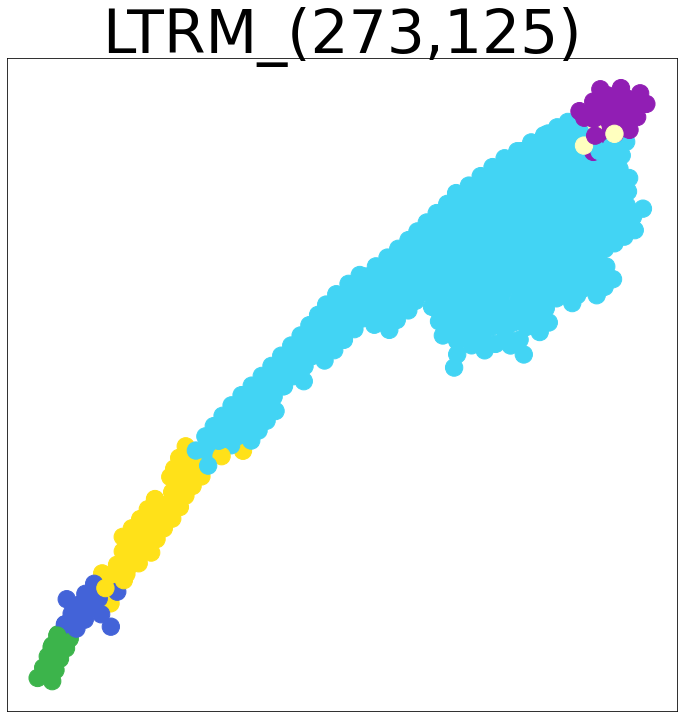

In [16]:
# Create graph
filepath = "LTRM_(273,125).png"
draw_graph(scomplex, filepath, with_labels = False)
append_states(scomplex, largestShape, X)

In [17]:
# Re-save scomplex and dataframe in pickle files
# Rename files accordingly
scomplex = pk.load(open('LTRM_(273,125).p', "rb"))
X = pk.load(open('LTRM_df_(273,125).p', "rb"))

## Make state columns

Note: Make sure that the dataframe, simplicial complex, and pickle file names match up

When the states are appended to the dataframe, it creates a dummy column for each state. The state is name by the node id of the local maximum associated with that state. The following edits are made to the dataframe:

1. Determine which nodes are the local maxima, print out how many data points are in each maxima, and match up counts with the State counts
2. Rename the state columns as "State 1", "State 2", etc. instead of node id names
3. Create a new column called "State" that will contain a string describing which state a row belongs to. 
 
   NOTE: This columns will be used primarily for coloring the simplicial complex by ecological state number and for performing any statistical analysis between states. Recall that many data points may be within two different states. For any data point that is contained within multiple nodes, we will randomly select which state that data point will be assigned to in the "State" column. Since this is being used primarily for visualization purposes, we can justify this action. We also when performing any MANOVA/ANOVA tests will need to take a subset of data points since our data set is so large, thus we can justify randomizing this state assignement. 
  
   NOTE: Some data points were not used in the main simplicial complex and will not have a state assignement. These data points will have a 'NA' in the 'State' columns and when the 'State' column is converted to a numerical column, will have a value of 0.

In [18]:
# STEP 1a
# Get the maxima node names to rename as 'State X'
print(scomplex['maxima'])

['cube1380_cluster0', 'cube1430_cluster0', 'cube24_cluster0', 'cube1123_cluster0', 'cube76_cluster0']


In [19]:
# STEP 1b
maxima = ['cube1380_cluster0', 'cube1430_cluster0', 'cube24_cluster0', 'cube1123_cluster0', 'cube76_cluster0']
for Max in maxima:
    print(Max + " has " + str(len(X[X[Max] == 1])) + " (" + str((len(X[X[Max] == 1]) / len(X) * 100)) + "%) samples.")

KeyError: 'cube1380_cluster0'

In [24]:
X

,WDP,TEMP,DO,VEL,TP,TN,SS,CHLcal,SHEETBAR,DATE,...,TP_color,TN_color,SS_color,CHLcal_color,State 4,State 5,State 1,State 3,State 2,State
0,-0.018088,0.572414,-0.72093,0.576923,0.481481,0.918033,0.361752,-0.294693,41000065,07/26/1993,...,0.481481,0.918033,0.361752,-0.294693,0,0,0,0,1,2
1,1.5323,0.572414,-0.72093,1.0,0.488889,1.547131,0.262323,-0.342123,41000066,07/26/1993,...,0.488889,1.547131,0.262323,-0.342123,0,0,0,0,1,2
2,0.524548,0.565517,-0.790698,0.884615,0.422222,0.918033,0.18828,-0.323151,41000067,07/26/1993,...,0.422222,0.918033,0.18828,-0.323151,0,0,0,0,1,2
3,1.764858,0.565517,-0.767442,0.942308,0.362963,1.124317,0.173472,-0.332637,41000068,07/26/1993,...,0.362963,1.124317,0.173472,-0.332637,0,0,0,0,1,2
4,1.144703,0.572414,-0.72093,0.923077,0.548148,0.969262,0.482336,-0.291531,41000069,07/26/1993,...,0.548148,0.969262,0.482336,-0.291531,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76664,-0.439276,0.675862,-0.813953,-0.365385,2.051852,-1.052596,1.822086,2.303613,46015274,08/07/2009,...,2.051852,-1.052596,1.822086,2.303613,0,0,0,0,1,2
76665,-0.44186,-0.431034,0.186047,-0.384615,1.525926,-0.596311,0.186165,0.620584,46019157,10/23/2013,...,1.525926,-0.596311,0.186165,0.620584,0,0,0,0,1,2
76666,-0.447028,-0.365517,0.22093,-0.384615,1.474074,-0.711066,0.105775,0.89303,46019158,10/23/2013,...,1.474074,-0.711066,0.105775,0.89303,0,0,0,0,1,2
76667,-0.421189,-0.441379,0.127907,-0.384615,1.474074,-0.61612,0.228475,0.644173,46019160,10/23/2013,...,1.474074,-0.61612,0.228475,0.644173,0,0,0,0,1,2


Match up the new state column names with these counts:

* State 1 has 15420 (20.112431360784672%) samples.
* State 2 has 65468 (85.39044463864143%) samples.
* State 3 has 1150 (1.4999543492154588%) samples.
* State 4 has 216 (0.2817305560265557%) samples.
* State 5 has 143 (0.18651606255461792%) samples.

In [25]:
# STEP 1c: Change state names accordingly  
X = X.rename(columns = {"cube24_cluster0": "State 1", 
                        "cube76_cluster0": "State 2", 
                        "cube1123_cluster0": "State 3",
                        "cube1380_cluster0": "State 4",
                        "cube1430_cluster0": "State 5"}) 

In [26]:
X

,WDP,TEMP,DO,VEL,TP,TN,SS,CHLcal,SHEETBAR,DATE,...,TP_color,TN_color,SS_color,CHLcal_color,State 4,State 5,State 1,State 3,State 2,State
0,-0.018088,0.572414,-0.72093,0.576923,0.481481,0.918033,0.361752,-0.294693,41000065,07/26/1993,...,0.481481,0.918033,0.361752,-0.294693,0,0,0,0,1,2
1,1.5323,0.572414,-0.72093,1.0,0.488889,1.547131,0.262323,-0.342123,41000066,07/26/1993,...,0.488889,1.547131,0.262323,-0.342123,0,0,0,0,1,2
2,0.524548,0.565517,-0.790698,0.884615,0.422222,0.918033,0.18828,-0.323151,41000067,07/26/1993,...,0.422222,0.918033,0.18828,-0.323151,0,0,0,0,1,2
3,1.764858,0.565517,-0.767442,0.942308,0.362963,1.124317,0.173472,-0.332637,41000068,07/26/1993,...,0.362963,1.124317,0.173472,-0.332637,0,0,0,0,1,2
4,1.144703,0.572414,-0.72093,0.923077,0.548148,0.969262,0.482336,-0.291531,41000069,07/26/1993,...,0.548148,0.969262,0.482336,-0.291531,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76664,-0.439276,0.675862,-0.813953,-0.365385,2.051852,-1.052596,1.822086,2.303613,46015274,08/07/2009,...,2.051852,-1.052596,1.822086,2.303613,0,0,0,0,1,2
76665,-0.44186,-0.431034,0.186047,-0.384615,1.525926,-0.596311,0.186165,0.620584,46019157,10/23/2013,...,1.525926,-0.596311,0.186165,0.620584,0,0,0,0,1,2
76666,-0.447028,-0.365517,0.22093,-0.384615,1.474074,-0.711066,0.105775,0.89303,46019158,10/23/2013,...,1.474074,-0.711066,0.105775,0.89303,0,0,0,0,1,2
76667,-0.421189,-0.441379,0.127907,-0.384615,1.474074,-0.61612,0.228475,0.644173,46019160,10/23/2013,...,1.474074,-0.61612,0.228475,0.644173,0,0,0,0,1,2


In [27]:
# STEP 2: randomize state assignment
states = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5']

X['State'] = ''
for index in X.index:
    temp = []
    for state in states:
        if X.at[index, state] == 1:
            temp.append(state)
    if (len(temp) != 0):
        X.at[index, 'State'] += random.choice(temp) 
    else:
        X.at[index, 'State'] += 'NA'

dict = {'State 1' : 1, 'State 2' : 2, 'State 3' : 3, 'State 4' : 4, 'State 5' : 5, 'NA' : 0}

X = X.replace({'State':dict})

## Create HTML with color values

We can create an html file that will allow us to view the simplicial complex colored by a set of numeric values. We choose the continuous water quality variables that we used to create the simplicial complex, and also add our new "State" columns. 

NOTE: The values that we use for the color are the variables will the lowered ceilieing so that outliers don't skew the color distribution.

In [28]:
# Create the list of color columns for the list of continuouse variables being used
variable_colors = []
for variable in continuous_variables:
    temp = variable
    temp += '_color'
    variable_colors.append(temp)

variable_colors.append('State')

mapper = km.KeplerMapper(verbose = 0)
var_to_index = {variable_colors[i] : i for i in range(len(variable_colors))}
projected_var_indices = [var_to_index[var] for var in variable_colors]

summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

y = np.array(X[variable_colors])

# Make HTML with color values as the continous variables
color_vals = X[variable_colors]
color_names = variable_colors
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_values = color_vals, 
                                                                 color_function_name = color_names)

html_output_path = 'LTRM_(273,125).html'
    
mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables, 
                custom_tooltips = y, node_color_function = ["mean", "std", "median", "max"])


TypeError: get_mapper_graph() got an unexpected keyword argument 'color_values'

Save simplicial complex and dataframe with maxima and state columns - change file names accordingly

In [75]:
pickle = pk.dump(scomplex, open("LTRM_(273,125).p", "wb"))
pickle = pk.dump(X, open("LTRM_df_(273,125).p", "wb"))

### Count how many samples are in each state

### Make CSV file

In [73]:
X.columns

Index(['WDP', 'TEMP', 'DO', 'VEL', 'TP', 'TN', 'SS', 'CHLcal', 'SHEETBAR',
       'DATE', 'LATTITUDE', 'LONGITUDE', 'FLDNUM', 'STRATUM', 'LOCATCD',
       'YEAR', 'SEASON', 'WDP_unscaled', 'TEMP_unscaled', 'DO_unscaled',
       'VEL_unscaled', 'TP_unscaled', 'TN_unscaled', 'SS_unscaled',
       'CHLcal_unscaled', '1993-2000', '1898-2004', '2001-2013', '2010-2016',
       '2014-2020', 'Backwater area contiguous to the main channel',
       'Impounded', 'Isolated', 'Lake Pepin or Swan Lake', 'Main channel',
       'Side channel', 'Unexploded Ordinance Area - Pool 13', 'Bellevue, IA',
       'Brighton, IL', 'Havana, IL', 'Jackson, MO', 'Lake City, MN',
       'Onalaska, WI', 'WDP_color', 'TEMP_color', 'DO_color', 'VEL_color',
       'TP_color', 'TN_color', 'SS_color', 'CHLcal_color', 'State 4',
       'State 5', 'State 1', 'State 3', 'State 2', 'State'],
      dtype='object')

In [74]:
X.to_csv('LTRM_(273,125).csv', index = False)